<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# PCA Lab: Speed Dating

_Authors: Kiefer Katovich (SF)_

---

Let's practice principal component analysis (PCA) using a data set from Kaggle. PCA is often used to simplify data, reduce noise, and find unmeasured latent variables, so it's important to take the time to understand what's going on.

**In this lab, we will:**

- Explore how PCA relates to correlation.
- Use PCA to perform dimensionality reduction.
- Predict whether or not a speed dater likes reading based on the dater's other likes.

---

### Data Set

The data set we're using for this lab is a subset of this [much more detailed speed dating data set](https://www.kaggle.com/annavictoria/speed-dating-experiment). In particular, this contains no information on the actual speed dating itself (i.e., successes with or opinions of other individuals). 

It also contains no follow-up information where individuals are asked the same questions about themselves again. It only contains information about what an individual enjoys doing, their self-ratings on how desirable they are, and how they think others rate them based on desirability.

The columns present in the data are outlined below:

FieldName|Description
---------|-----------
    subject_id                   |   Unique individual identifier.
    wave                         |   Meetup ID.
    like_sports                  |   Enjoyment of participating in sports.
    like_tvsports                |   Enjoyment of watching sports on TV.
    like_exercise                |   Enjoyment of exercise.
    like_food                    |   Enjoyment of food.
    like_museums                 |   Enjoyment of museums.
    like_art                     |   Enjoyment of art.
    like_hiking                  |   Enjoyment of hiking.
    like_gaming                  |   Enjoyment of playing games.
    like_clubbing                |   Enjoyment of going clubbing/partying.
    like_reading                 |   Enjoyment of reading.
    like_tv                      |   Enjoyment of TV in general.
    like_theater                 |   Enjoyment of the theater (plays, musicals, etc.).
    like_movies                  |   Enjoyment of movies.
    like_concerts                |   Enjoyment of concerts.
    like_music                   |   Enjoyment of music.
    like_shopping                |   Enjoyment of shopping.
    like_yoga                    |   Enjoyment of yoga.
    subjective_attractiveness    |   How attractive they rate themselves.
    subjective_sincerity         |   How sincere they rate themselves.
    subjective_intelligence      |   How intelligent they rate themselves.
    subjective_fun               |   How fun they rate themselves.
    subjective_ambition          |   How ambitious they rate themselves.
    objective_attractiveness     |   Perceived rating others would give them on how attractive they are.
    objective_sincerity          |   Perceived rating others would give them on how sincere they are.
    objective_intelligence       |   Perceived rating others would give them on how intelligent they are.
    objective_fun                |   Perceived rating others would give them on how fun they are.
    objective_ambition           |   Perceived rating others would give them on how ambitious they are.
    
There are 551 subjects total.

---

### 1) Load packages.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

%config InlineBackend.figure_format = 'retina'

---

### 2) Load and clean the speed dating data.

- First, remove columns with more than 200 missing values.
- Then, remove rows with missing values.
- Verify that no rows contain NaNs.

In [6]:
sd = pd.read_csv('./datasets/speed_dating.csv')
sd.columns

Index(['subject_id', 'wave', 'like_sports', 'like_tvsports', 'like_exercise',
       'like_food', 'like_museums', 'like_art', 'like_hiking', 'like_gaming',
       'like_clubbing', 'like_reading', 'like_tv', 'like_theater',
       'like_movies', 'like_concerts', 'like_music', 'like_shopping',
       'like_yoga', 'subjective_attractiveness', 'subjective_sincerity',
       'subjective_intelligence', 'subjective_fun', 'subjective_ambition',
       'objective_attractiveness', 'objective_sincerity',
       'objective_intelligence', 'objective_fun', 'objective_ambition'],
      dtype='object')

In [7]:
sd.shape

(551, 29)

In [8]:
# Check NULL
# Remove columns with more than 200 missing values.
# objective_attractiveness     237
# objective_sincerity          237
# objective_intelligence       237
# objective_fun                237
# objective_ambition           237

# Remove rows with missing values.
# The rest, exept ...
# subject_id                     0
# wave                           0
sd.isnull().sum()

subject_id                     0
wave                           0
like_sports                    7
like_tvsports                  7
like_exercise                  7
like_food                      7
like_museums                   7
like_art                       7
like_hiking                    7
like_gaming                    7
like_clubbing                  7
like_reading                   7
like_tv                        7
like_theater                   7
like_movies                    7
like_concerts                  7
like_music                     7
like_shopping                  7
like_yoga                      7
subjective_attractiveness      9
subjective_sincerity           9
subjective_intelligence        9
subjective_fun                 9
subjective_ambition            9
objective_attractiveness     237
objective_sincerity          237
objective_intelligence       237
objective_fun                237
objective_ambition           237
dtype: int64

In [9]:
# Remove columns (Null > 200)
sd.drop(columns=['objective_attractiveness', 
                 'objective_sincerity', 
                 'objective_intelligence', 
                 'objective_fun', 
                 'objective_ambition'], inplace=True)

In [10]:
# Remove rows with missing values.
sd.dropna(inplace=True)

In [11]:
# Check NULL again
sd.isnull().sum()

subject_id                   0
wave                         0
like_sports                  0
like_tvsports                0
like_exercise                0
like_food                    0
like_museums                 0
like_art                     0
like_hiking                  0
like_gaming                  0
like_clubbing                0
like_reading                 0
like_tv                      0
like_theater                 0
like_movies                  0
like_concerts                0
like_music                   0
like_shopping                0
like_yoga                    0
subjective_attractiveness    0
subjective_sincerity         0
subjective_intelligence      0
subjective_fun               0
subjective_ambition          0
dtype: int64

---

### 3) Example: Are the `subjective` columns correlated?

Here, we'll understand how the `subjective` columns are correlated.

- Find the z scores of each `subjective` column (i.e. standardize the `subjective` columns).
- Visualize correlation using [PairGrid](https://seaborn.pydata.org/generated/seaborn.PairGrid.html).
- Visualize correlation using a heat map.

**3.A) Find the z scores of each column. This allows the columns to more easily be directly compared.**

In [14]:
subjective_cols = [col for col in sd.columns \
                   if col.startswith('subjective')]
subjective_cols # Check the col. in subjective_cols

['subjective_attractiveness',
 'subjective_sincerity',
 'subjective_intelligence',
 'subjective_fun',
 'subjective_ambition']

In [15]:
# Standardize
sc = StandardScaler()

# Fit and transform the subjective columns to calculate z-scores
subjective_sc = pd.DataFrame(sc.fit_transform(sd[subjective_cols]), 
                          columns=subjective_cols)

# Display the Z_score
subjective_sc.head()

,subjective_attractiveness,subjective_sincerity,subjective_intelligence,subjective_fun,subjective_ambition
0,-0.786472,-0.202716,-0.354194,0.193323,-0.323589
1,-0.066425,-2.329267,-0.354194,1.486916,-2.564932
2,0.653622,0.506135,0.564338,0.193323,0.236747
3,-0.066425,-0.202716,-1.272726,0.840119,0.236747
4,-0.786472,-3.746968,1.482870,-1.100270,0.236747


**3.B) Use a PairGrid to visualize correlation.**

[`PairGrid`](https://seaborn.pydata.org/generated/seaborn.PairGrid.html) is more general version of `pairplot`.  For example, you could use the following code, where `subjective` is a data frame containing only the subjective columns:

```python
g = sns.PairGrid(subjective)
# Regression plots in lower triangle
g = g.map_lower(sns.regplot) 
g = g.map_upper(sns.kdeplot, cmap="Blues", shade=True, shade_lowest=False)  # KDE plots in upper triangle
g = g.map_diag(plt.hist) # Histograms along diagonal

plt.show()
```

In [18]:
# I USE THE PROVIDED CODE AND GOT PINK WARNING
# Due to 
# `shade` is now deprecated in favor of `fill`; setting `fill=True`.
# `shade_lowest` has been replaced by `thresh`
# This will become an error in seaborn v0.14.0; 

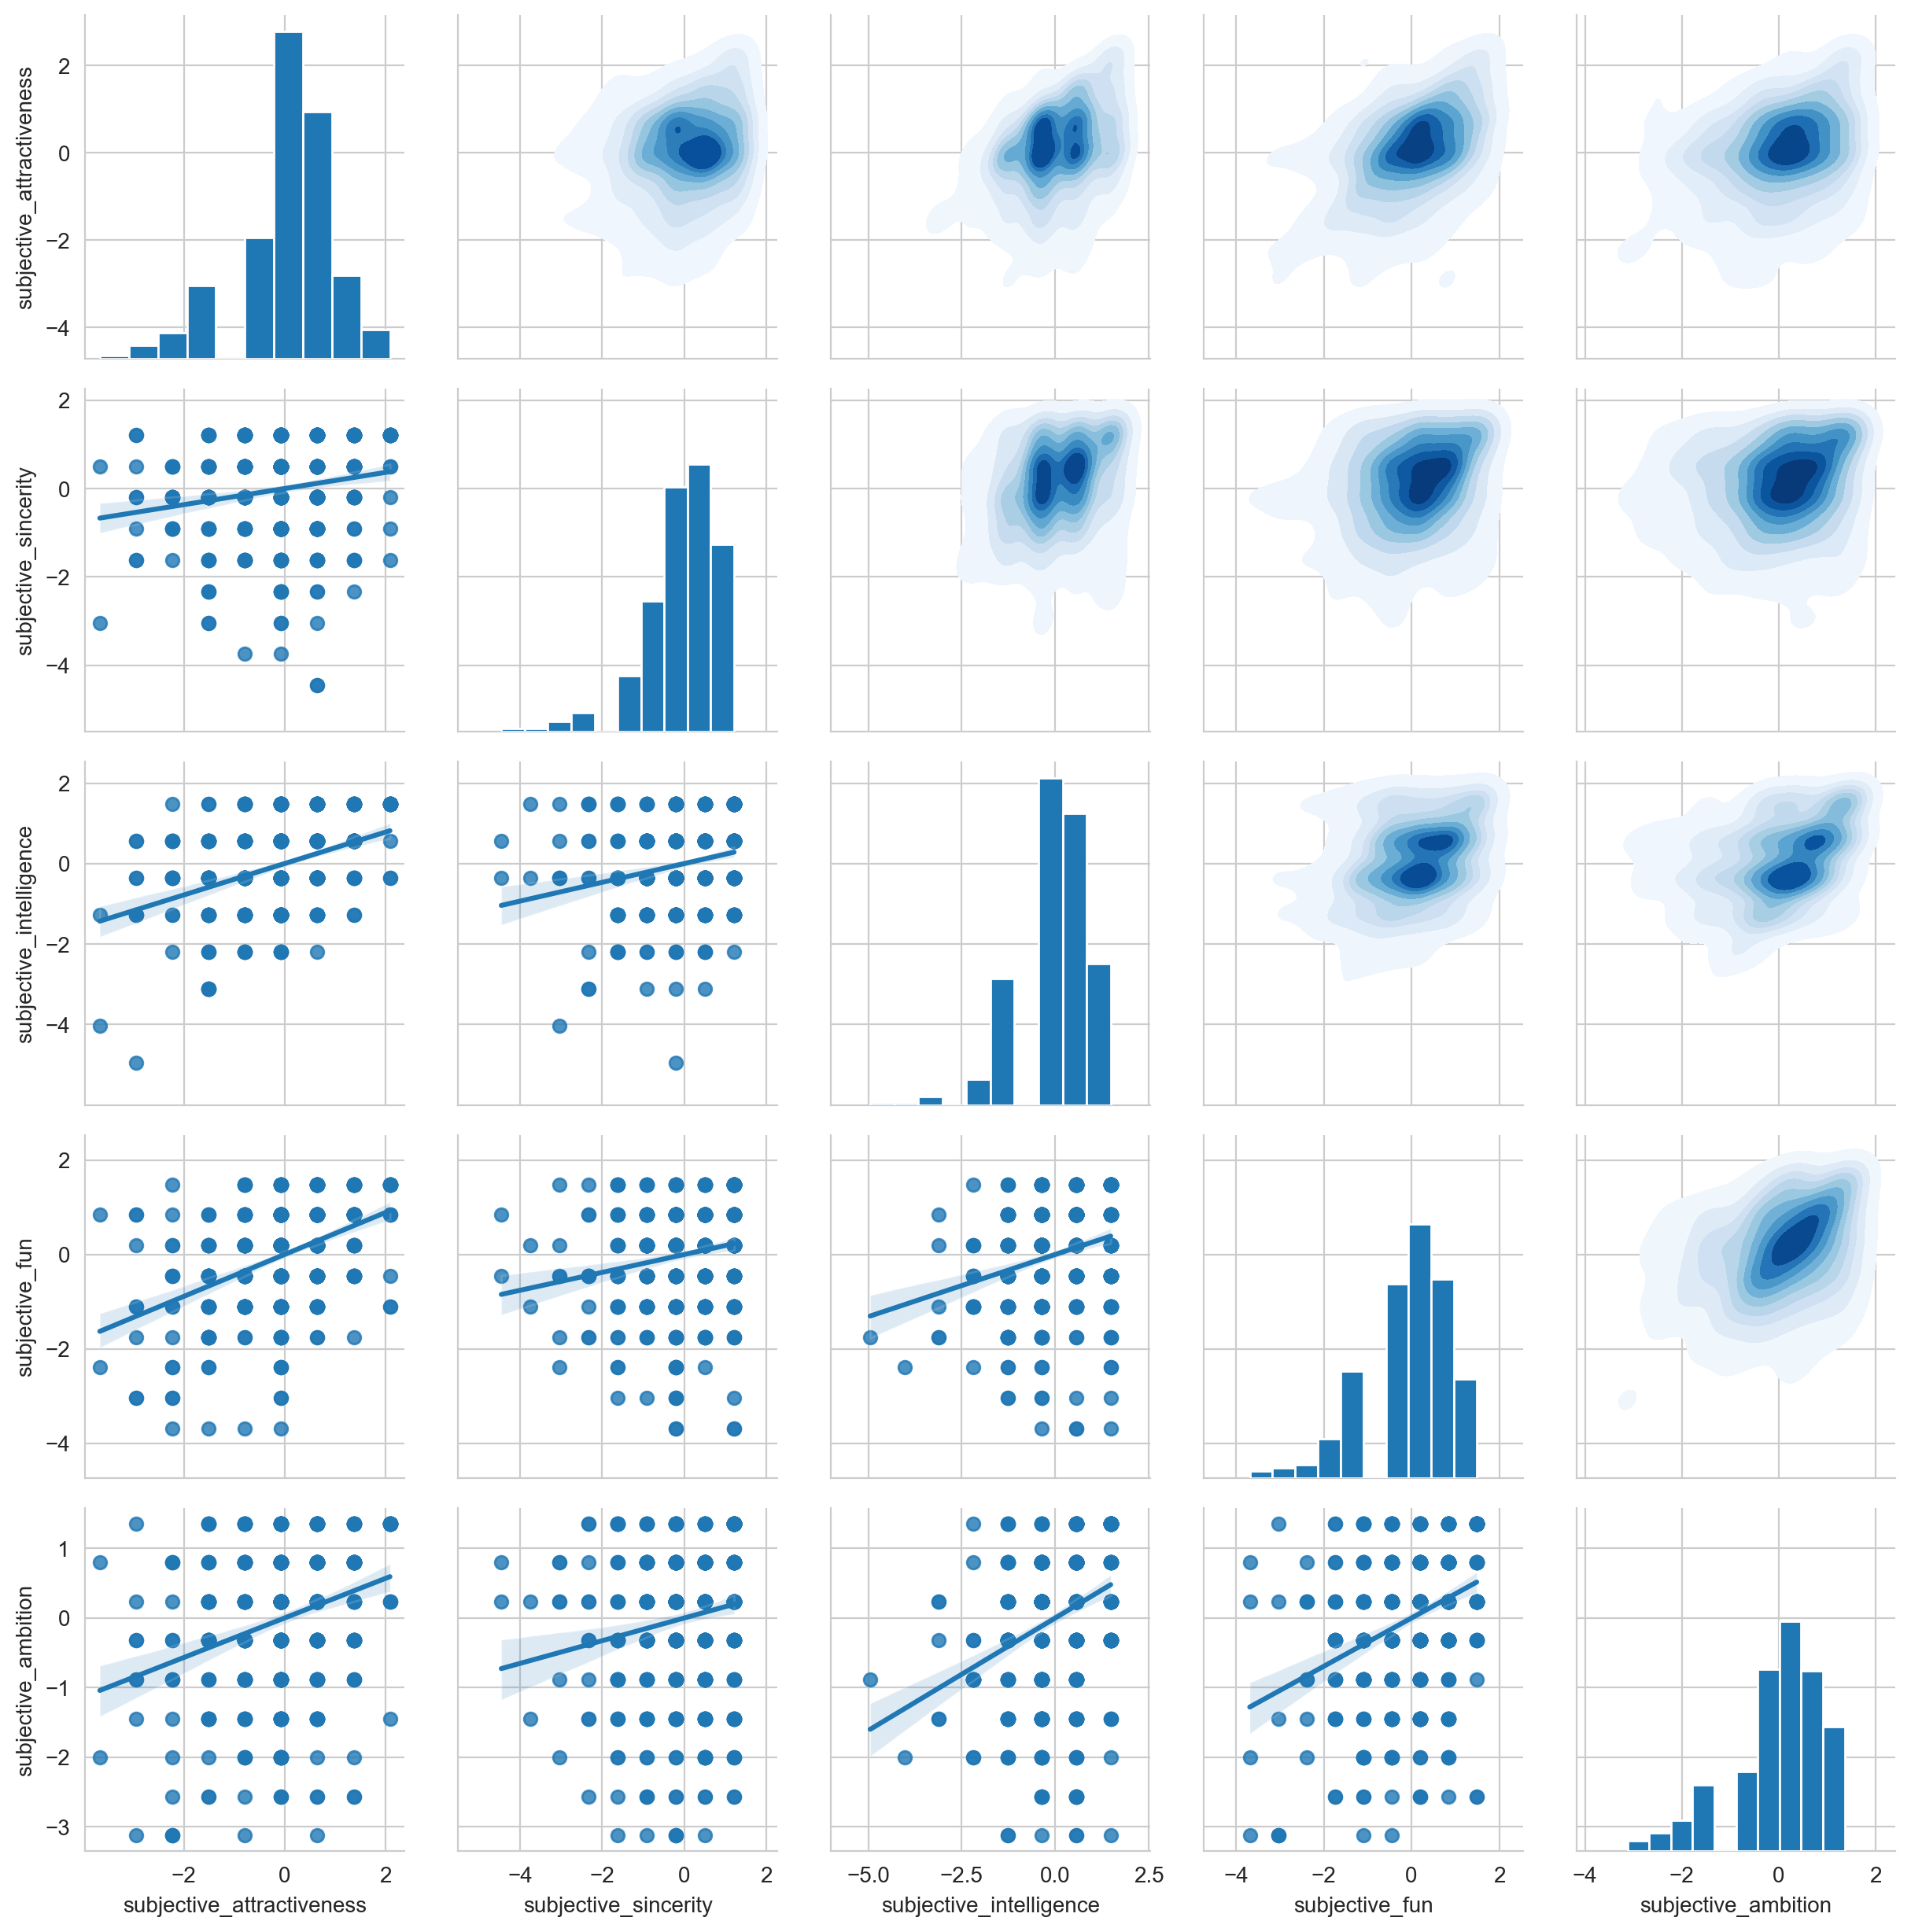

In [19]:
# I updated code from shade to fill and shade_lowest to thresh
g = sns.PairGrid(subjective_sc)
g = g.map_lower(sns.regplot)
g = g.map_upper(sns.kdeplot, cmap="Blues", fill=True, thresh=0.05)
g = g.map_diag(plt.hist);
plt.show()

**3.C) Use a heat map to visualize correlation.**

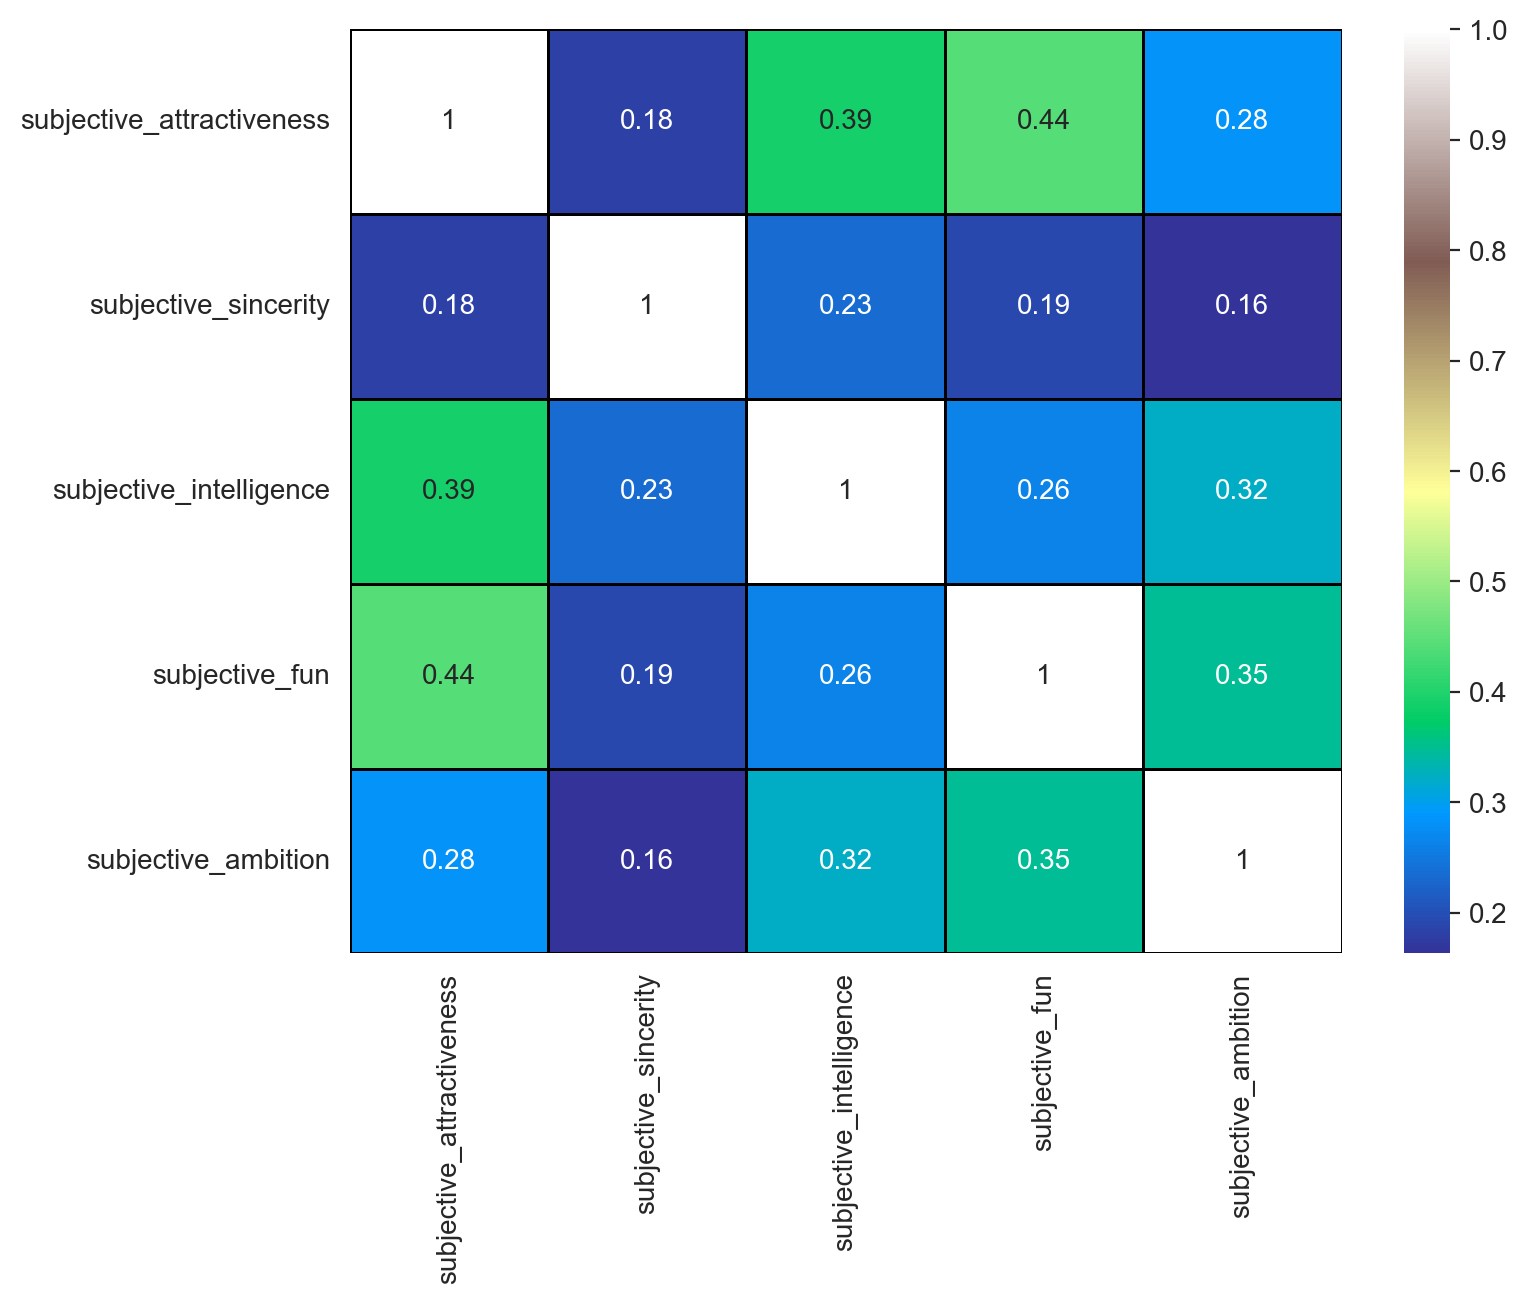

In [21]:
# A:
plt.figure(figsize=(8,6))
sns.heatmap(subjective_sc.corr(), 
            annot = True, 
            linewidths=1,
            linecolor='black',
            cmap = 'terrain');

---

**Important: Did you ensure the results make sense intuitively?** If not, look at the results again. You should **always** interpret your results and ensure they make sense based on what you expected. If they don’t, investigate why — sometimes your analysis or data are wrong.

> For example, the results show that believing you are attractive and fun are correlated. Would you expect that believing you are intellectual and fun to have a higher or lower correlation? What do the results say?

---


### 4) Visualize some preference columns.

Next, we’ll explore how some preference ratings are correlated. You saw an example — now try it on the `preference_cols` below.

- Find the z scores of each column in `preference_cols`.
- Visualize correlation using PairGrid.
- Visualize correlation using a heat map.
- Do these results make sense intuitively? 

In [23]:
preference_cols = ['like_tvsports', 'like_sports', 'like_museums', 
                   'like_theater', 'like_shopping']
sd_like = sd[preference_cols]

**4.A) Find the z scores of each column in `preference_cols`.**

In [25]:
# A:

# Standardize
sc = StandardScaler()

# Fit and transform the subjective columns to calculate z-scores
preference_sc = pd.DataFrame(sc.fit_transform(sd_like[preference_cols]), 
                           columns=preference_cols)
# Display the Z_score
sd_like.head()

,like_tvsports,like_sports,like_museums,like_theater,like_shopping
0,2.0,9.0,1.0,1.0,8.0
1,2.0,3.0,8.0,9.0,3.0
2,8.0,3.0,5.0,7.0,8.0
3,1.0,1.0,6.0,9.0,1.0
4,4.0,7.0,6.0,6.0,8.0


**4.B) Visualize correlation using PairGrid.**

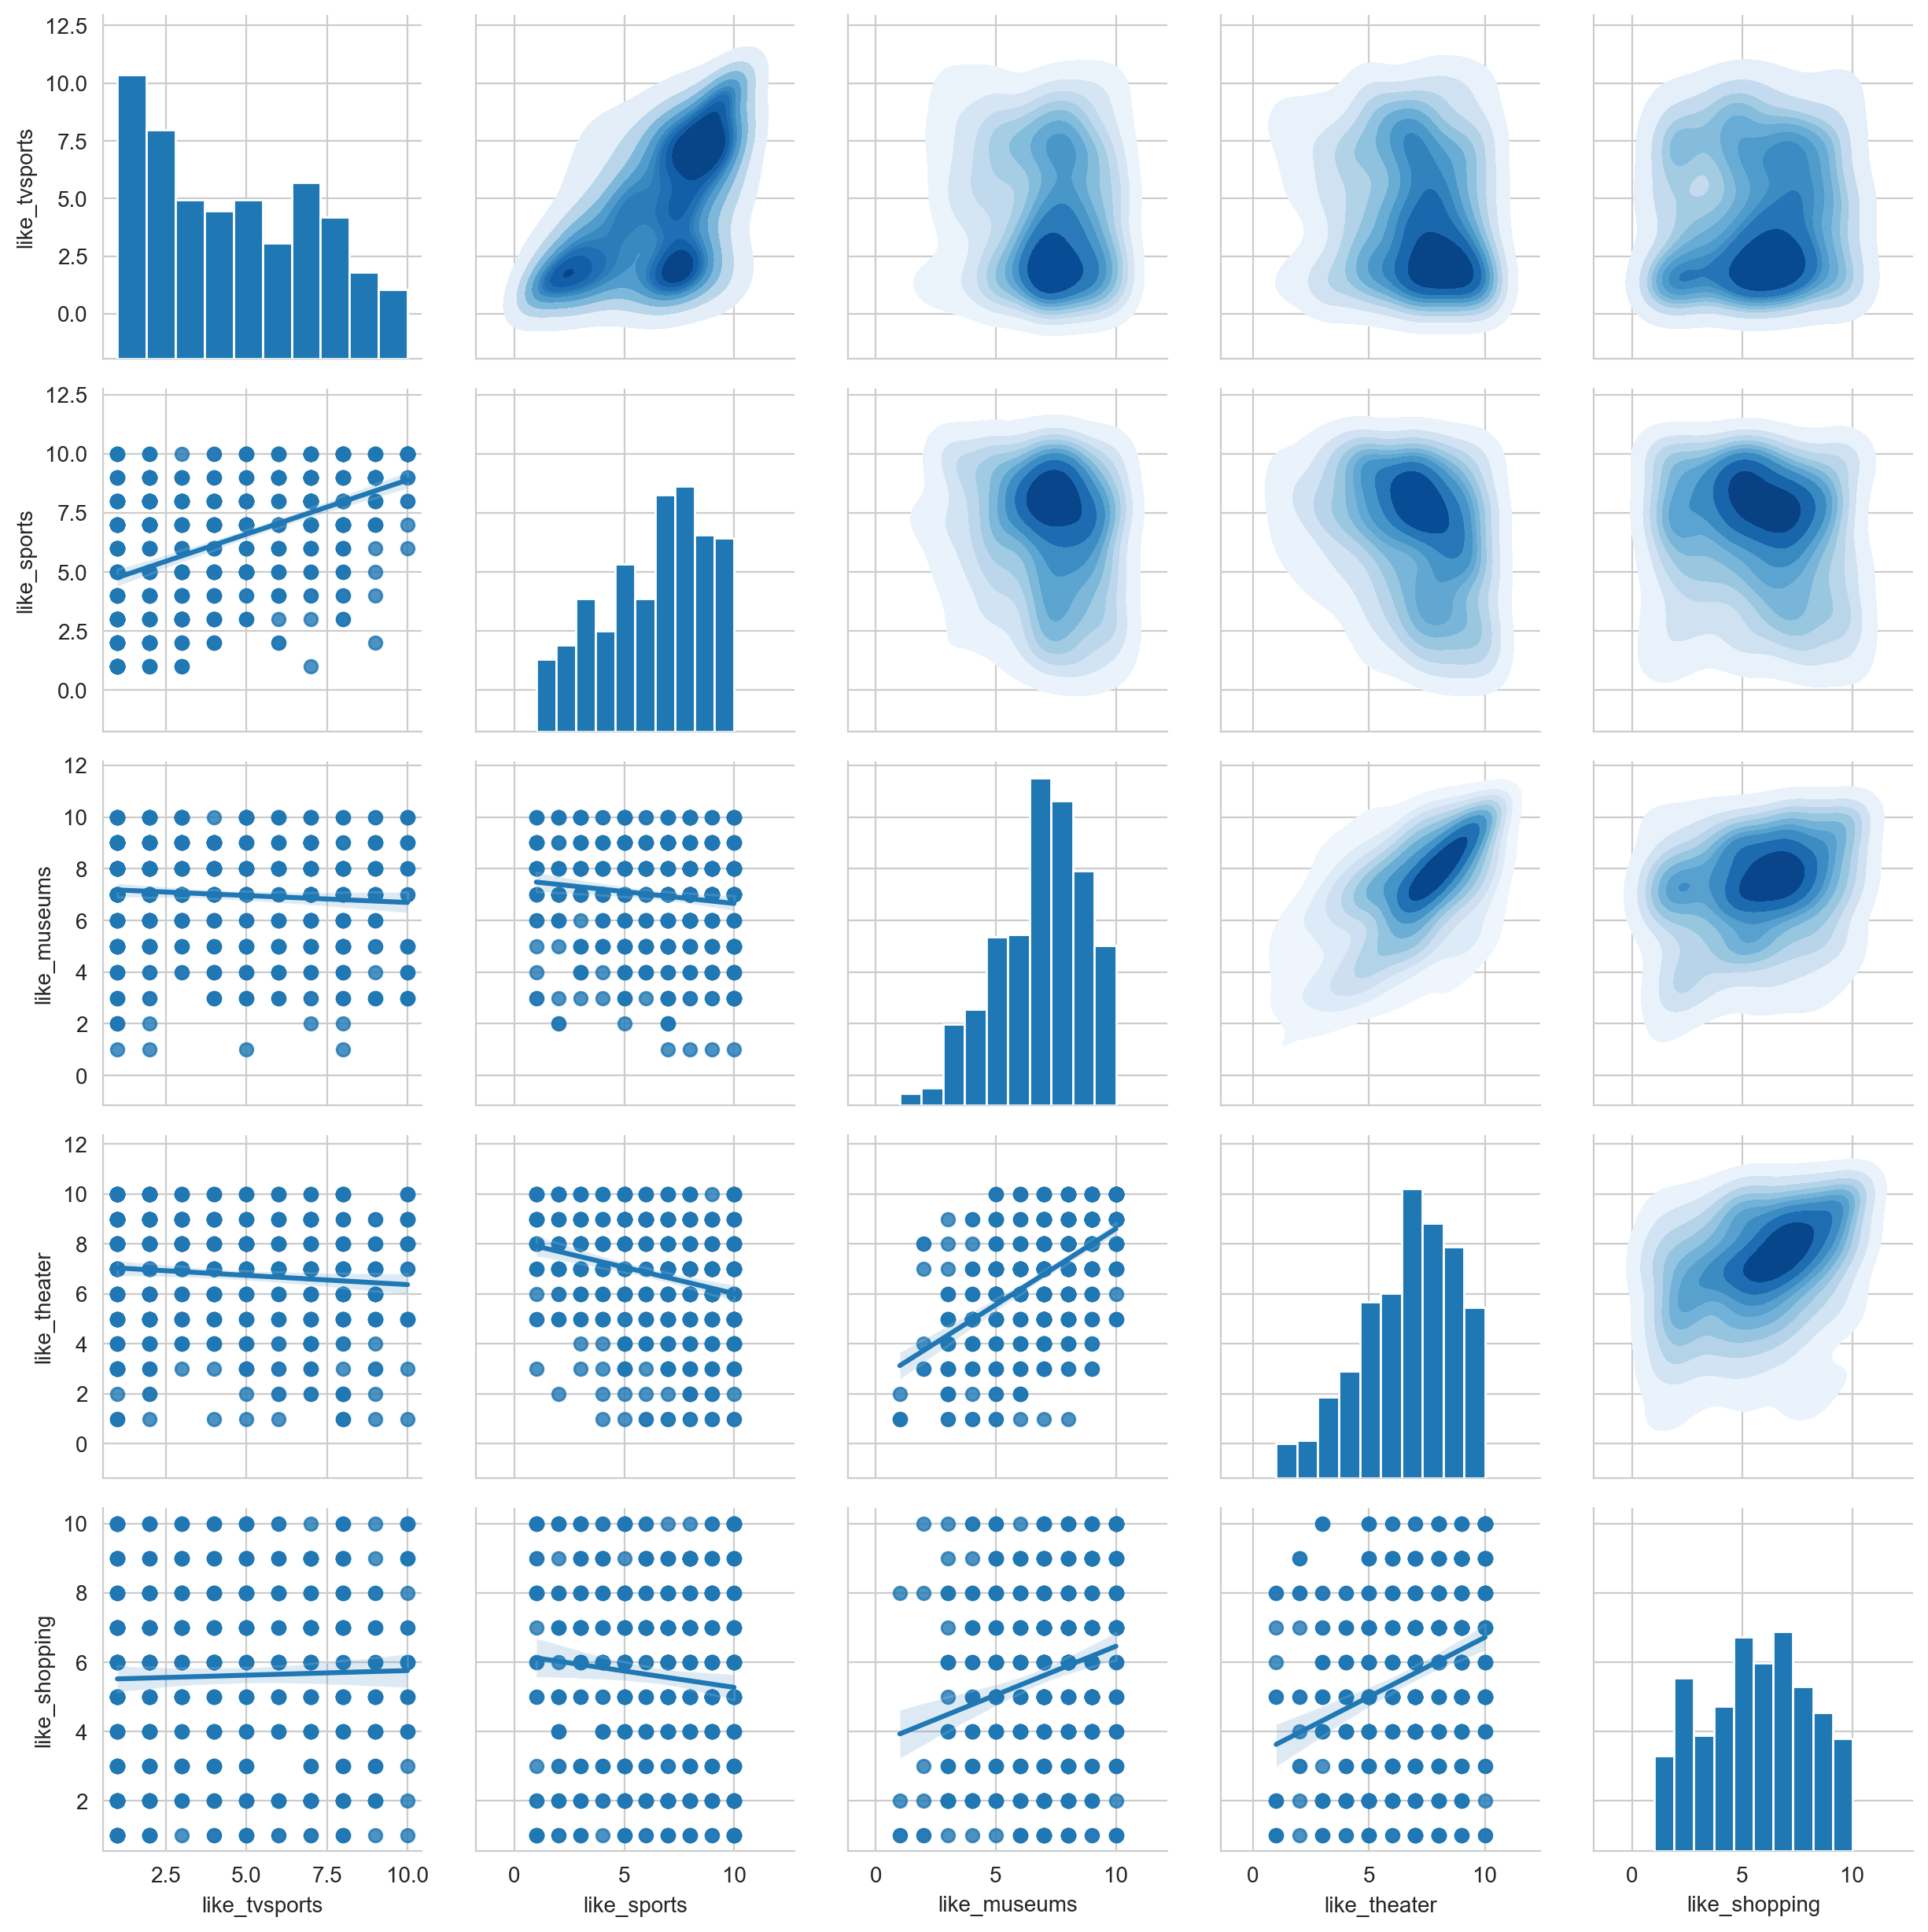

In [27]:
# A:
g = sns.PairGrid(sd_like)
g = g.map_lower(sns.regplot)
g = g.map_upper(sns.kdeplot, cmap="Blues", fill=True, thresh=0.05)
g = g.map_diag(plt.hist);

**4.C) Visualize correlation using a heat map.**

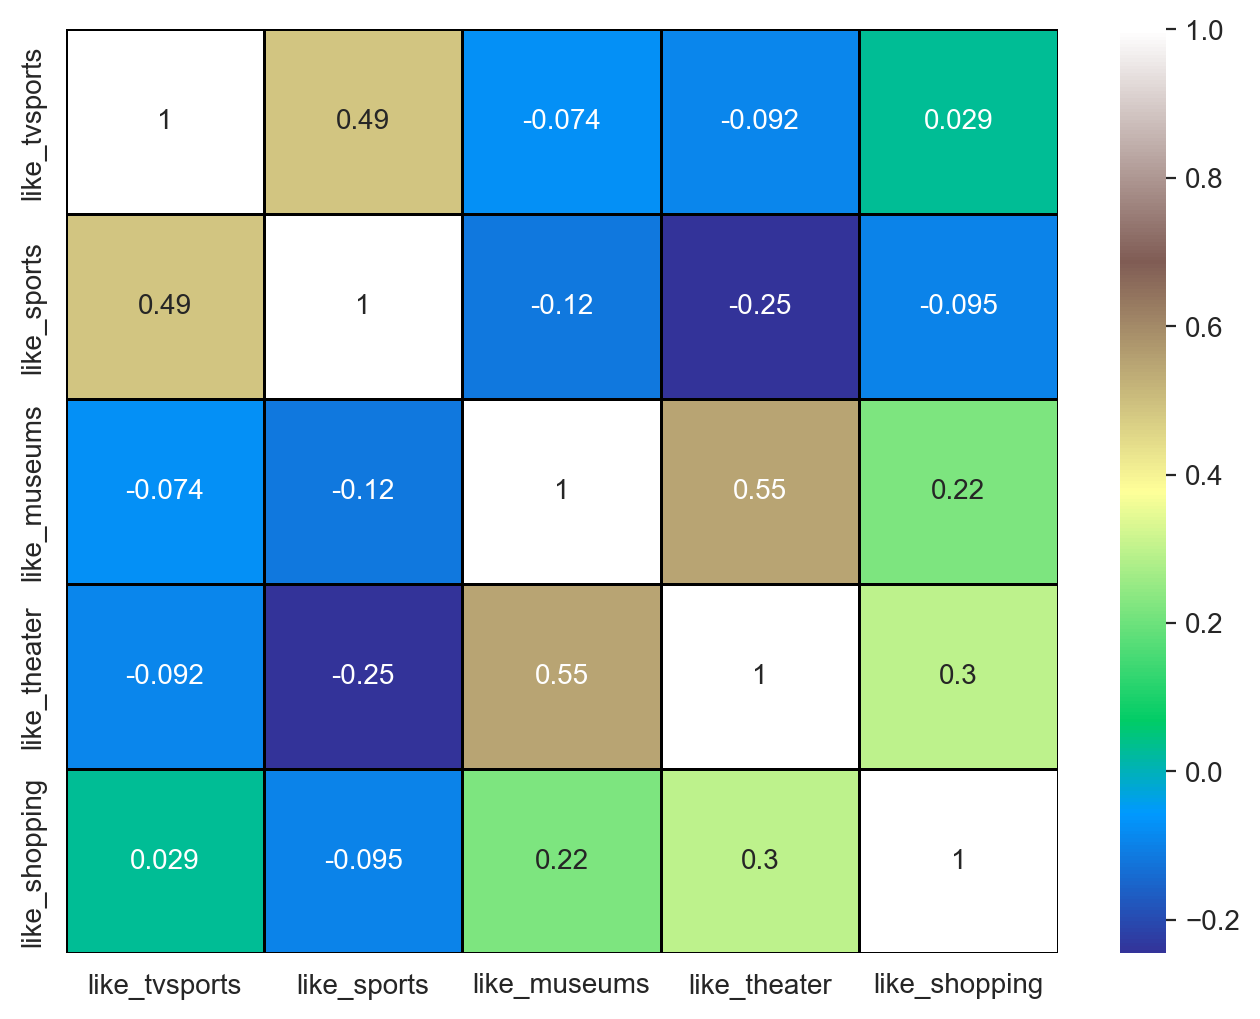

In [29]:
# A:
plt.figure(figsize=(8,6))
sns.heatmap(sd_like.corr(), 
            annot = True, 
            linewidths=1,
            linecolor='black',
            cmap = 'terrain');

---

### 5) Example: Fit PCA on the subjective ratings.

In [31]:
# PCA
subjective_pca = PCA(n_components=5)
subjective_pca.fit(subjective_sc)

PCA(n_components=5)

In [32]:
subjective_sc

,subjective_attractiveness,subjective_sincerity,subjective_intelligence,subjective_fun,subjective_ambition
0,-0.786472,-0.202716,-0.354194,0.193323,-0.323589
1,-0.066425,-2.329267,-0.354194,1.486916,-2.564932
2,0.653622,0.506135,0.564338,0.193323,0.236747
3,-0.066425,-0.202716,-1.272726,0.840119,0.236747
4,-0.786472,-3.746968,1.482870,-1.100270,0.236747
...,...,...,...,...,...
537,2.093717,1.214985,1.482870,1.486916,1.357419
538,-0.066425,1.214985,0.564338,0.193323,0.797083
539,-0.066425,-0.911566,-1.272726,-0.453474,-0.323589
540,-0.066425,-0.202716,-0.354194,-3.040659,-1.444260


---

**5.A) Look at the weights of the principal components.**

The principal components (or eigenvectors!) are simply the weights or coefficients on the original variables $X$ that transforms them to $Z$.

In [34]:
# A:
# Get the principal components' weights (components_)
weights_subjective_pca = pd.DataFrame(subjective_pca.components_, columns=subjective_sc.columns)

# Display the first 5 principal components weights 
print(f'First 5 principal components weights:\n{weights_subjective_pca.head(5)}')

First 5 principal components weights:
   subjective_attractiveness  subjective_sincerity  subjective_intelligence  \
0                  -0.501894             -0.315290                -0.467071   
1                   0.218260             -0.909060                -0.097690   
2                  -0.402024             -0.144386                 0.422893   
3                   0.348119             -0.213776                 0.648420   
4                  -0.646263             -0.087491                 0.415949   

   subjective_fun  subjective_ambition  
0       -0.483864            -0.443187  
1        0.274010             0.203342  
2       -0.481414             0.637912  
3       -0.361047            -0.531328  
4        0.573306            -0.270179  


In [35]:
# NOTE
# Weights (Loadings): 
# The weights are the coefficients of the linear combinations of the original features that form the principal components.

# The higher the magnitude of a weight, the more influence that feature has on the principal component.

---

**5.B) Look at the explained variance values (aka eigenvalues) and the explained variance ratios.**

The eigenvalues are ordered such that the first components have the largest eigenvalues. The values and their normalized equivalent in the explained variance ratio attribute tell you how much of the variance in the original data is encapsulated in the new component variables.

In [37]:
# A:

# Get the eigenvalues
print(subjective_pca.explained_variance_)

# Get the explained variance ratio
print(subjective_pca.explained_variance_ratio_)

[2.16041482 0.88925024 0.73820887 0.72229813 0.49907009]
[0.43128576 0.17752191 0.14736937 0.14419309 0.09962986]


In [38]:
# NOTE
#  Eigenvalues, representing the variance captured by each principal component (PC) in dataset.
# Explained variance ratio,  represent the proportion of the total variance explained by each principal component.

# From the output (above)
# PC1: 43.13% This is the most significant component.

---

**5.C) Transform the subjective data into the principal component space.**

The `transform()` function in the PCA will create your new component variable matrix.

In [40]:
# A:
subjective_transform = subjective_pca.transform(subjective_sc)
subjective_transformed_df = pd.DataFrame(subjective_transform, columns=subjective_cols)

This transformed our five-dimensional data set into vectors along its five principal components (with zero loss).
- Using these, we can now reduce the dimensionality of our data while minimizing loss.
- For example, taking only the first three eigenvectors accounts for `0.431 + 0.178 + 0.147 = 75.6%` of the variance.

In [42]:
# A: 
round(sum(subjective_pca.explained_variance_ratio_[0:3])*100,2)

75.62

---

**5.D) PCA-transformed features are not correlated.**

- Keep in mind that each column in the transformed data is no longer correlated.
- Compare this to the exploration above where many columns were correlated.

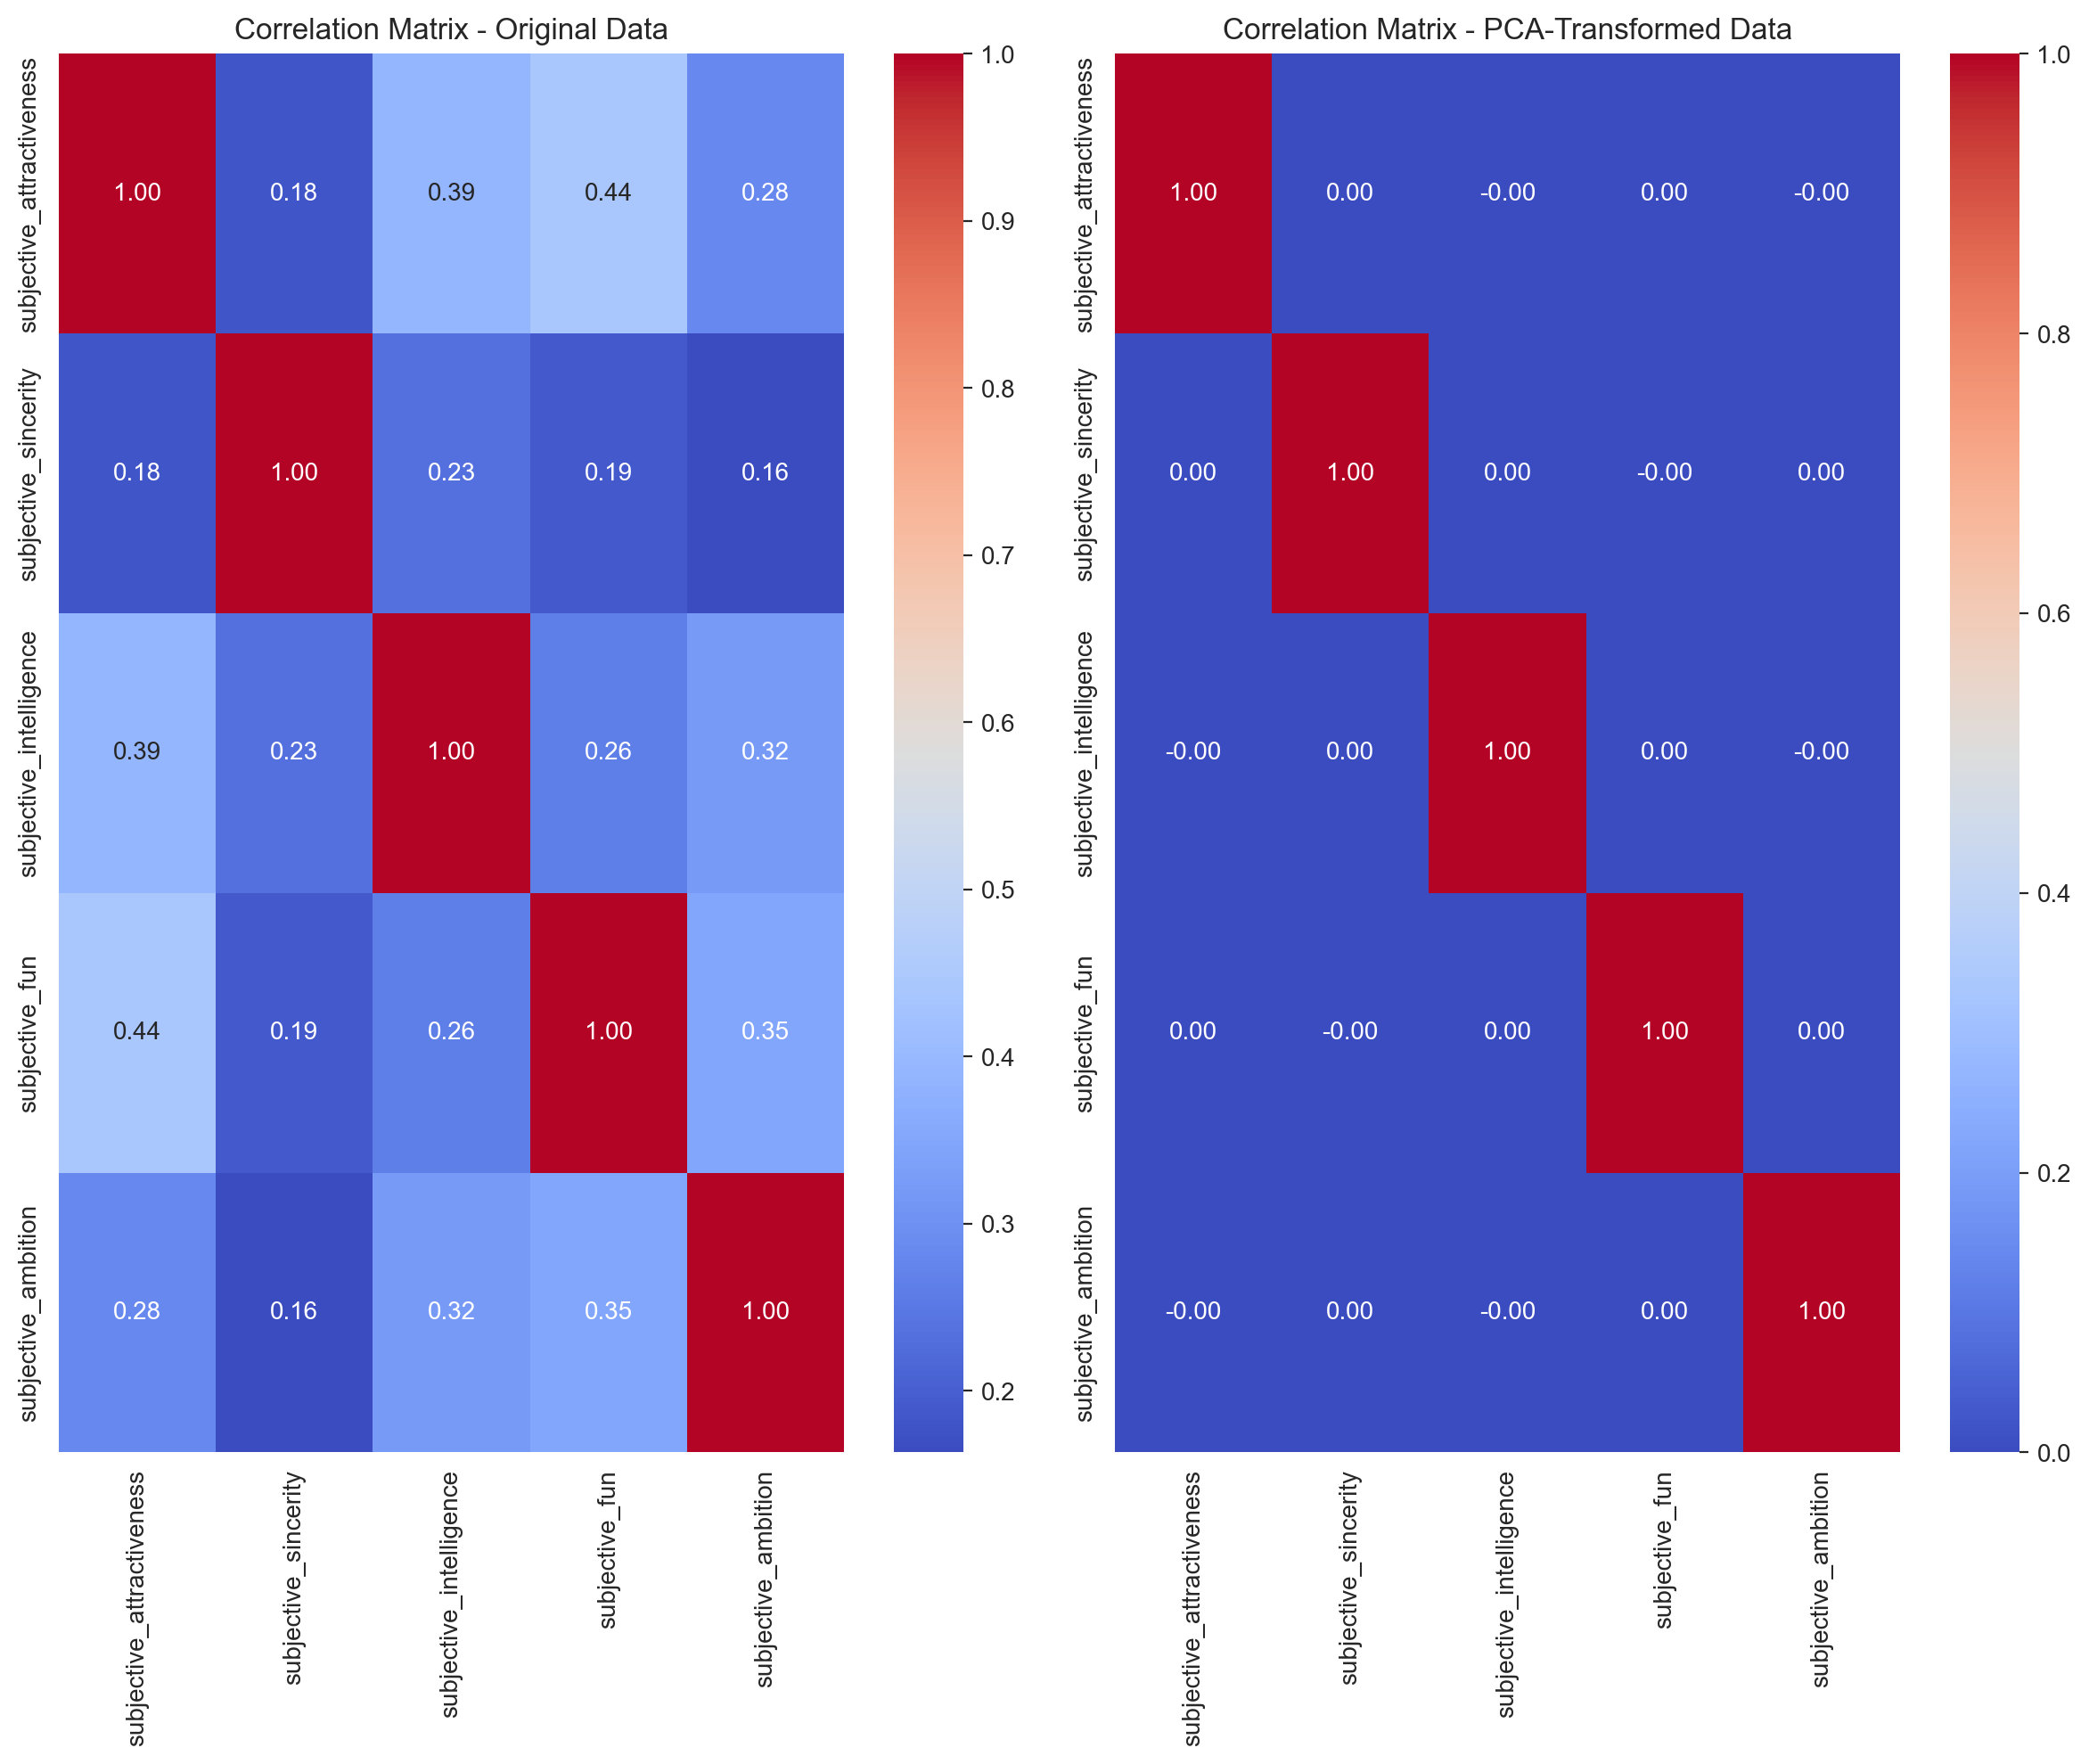

In [44]:
# 1. Correlation matrix of the original data
original_corr = subjective_sc.corr()

# 2. Correlation matrix of PCA-transformed data
pca_transform_corr = subjective_transformed_df.corr()

# Visualization
plt.figure(figsize=(12, 10))
plt.subplot(1, 2, 1) # Put along
sns.heatmap(original_corr, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title("Correlation Matrix - Original Data")

plt.subplot(1, 2, 2) # Put along
sns.heatmap(pca_transform_corr, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title("Correlation Matrix - PCA-Transformed Data")

plt.tight_layout()
plt.show()


---

### 6) Optional: How were the data transformed?

To demonstrate how the new principal component matrix is created from the original variable columns and the eigenvector weighting matrix, we'll create the first component (PC1) manually.

**6.A) Pull out the eigenvector for PC1.**

In [46]:
# A:
# Eigenvector for PC1
pc1_eigenvector = subjective_pca.components_[0] # [0] as we want the first PC1
pc1_eigenvector

array([-0.50189394, -0.31528977, -0.46707122, -0.48386412, -0.44318711])

**6.B) Create a DataFrame showing the original values for the subjective variables for `person1`.**

In [48]:
# A:
person1_df = subjective_sc.iloc[[0]]
person1_df

,subjective_attractiveness,subjective_sincerity,subjective_intelligence,subjective_fun,subjective_ambition
0,-0.786472,-0.202716,-0.354194,0.193323,-0.323589


**6.C) Add the eigenvector for PC1: the weights by which to multiply each original variable.**

Recall that each component is a linear combination of the original variables, multiplied by a "weight" defined in the eigenvector of that component.

In [50]:
# A:
pc1_weights_df = pd.DataFrame({'Original Values': subjective_sc.iloc[0], 'PC1 Weights': pc1_eigenvector})
pc1_weights_df

,Original Values,PC1 Weights
subjective_attractiveness,-0.786472,-0.501894
subjective_sincerity,-0.202716,-0.315290
subjective_intelligence,-0.354194,-0.467071
subjective_fun,0.193323,-0.483864
subjective_ambition,-0.323589,-0.443187


**6.D) Multiply the original variable values by the eigenvector values.**

These are the "pieces" of PC1 that will be added together to create the new value for that person.

In [52]:
# A:
# Multiply original values by PC1 weights
pc1_weights_df['PC1 Multiply'] = pc1_weights_df['Original Values'] * pc1_weights_df['PC1 Weights']
pc1_weights_df

,Original Values,PC1 Weights,PC1 Multiply
subjective_attractiveness,-0.786472,-0.501894,0.394726
subjective_sincerity,-0.202716,-0.315290,0.063914
subjective_intelligence,-0.354194,-0.467071,0.165434
subjective_fun,0.193323,-0.483864,-0.093542
subjective_ambition,-0.323589,-0.443187,0.143410


**6.E) Sum the original values multiplied by the eigenvector weights to get `person1`’s value for PC1.**

In [54]:
# A:
# Calculate PC1 value for person1
pc1_weights_df['PC1 Multiply'].sum().round(2)

0.67

---

### 7) Fit PCA on the preference data.

Now that you've seen how it's done, try it yourself!

- Find PCA eigenvalues and eigenvectors for the five `sd_like` columns.
- Transform the original `sd_like` columns into the principal component space.
- Verify that these columns are uncorrelated.

In [86]:
#A:
sd_like.head()

,like_tvsports,like_sports,like_museums,like_theater,like_shopping
0,2.0,9.0,1.0,1.0,8.0
1,2.0,3.0,8.0,9.0,3.0
2,8.0,3.0,5.0,7.0,8.0
3,1.0,1.0,6.0,9.0,1.0
4,4.0,7.0,6.0,6.0,8.0


#### 7.A) Find PCA eigenvalues and eigenvectors for the five `sd_like` columns.

In [94]:
# A: 
# fit
like_pca = PCA(n_components=5)
like_pca.fit(preference_sc)

# Eigenvalues 
eigenvalues = like_pca.explained_variance_

# Eigenvectors
eigenvectors = like_pca.components_

eigenvalues
eigenvectors

array([[ 3.20753112e-01,  4.30670129e-01, -5.13289220e-01,
        -5.73131676e-01, -3.45969565e-01],
       [ 6.49921628e-01,  5.32191987e-01,  3.24132297e-01,
         2.65063681e-01,  3.45040672e-01],
       [ 2.08050622e-05, -1.60309917e-01, -4.54907251e-01,
        -2.24216382e-01,  8.46809977e-01],
       [ 6.22451715e-01, -5.87488681e-01, -3.38227940e-01,
         3.33354423e-01, -2.04664607e-01],
       [ 2.95420347e-01, -4.00565486e-01,  5.56896475e-01,
        -6.63221810e-01,  4.77206044e-02]])

In [96]:
# Eigenvalues
eigenvalues

array([1.9118142 , 1.34365795, 0.82318062, 0.52097299, 0.40961638])

In [98]:
# Eigenvectors
eigenvectors

array([[ 3.20753112e-01,  4.30670129e-01, -5.13289220e-01,
        -5.73131676e-01, -3.45969565e-01],
       [ 6.49921628e-01,  5.32191987e-01,  3.24132297e-01,
         2.65063681e-01,  3.45040672e-01],
       [ 2.08050622e-05, -1.60309917e-01, -4.54907251e-01,
        -2.24216382e-01,  8.46809977e-01],
       [ 6.22451715e-01, -5.87488681e-01, -3.38227940e-01,
         3.33354423e-01, -2.04664607e-01],
       [ 2.95420347e-01, -4.00565486e-01,  5.56896475e-01,
        -6.63221810e-01,  4.77206044e-02]])

#### 7.B) Transform the original `sd_like` columns into the principal component space.

In [100]:
# A:
like_transformed = pd.DataFrame(like_pca.transform(preference_sc), 
                                columns=preference_cols)
like_transformed.head()

,like_tvsports,like_sports,like_museums,like_theater,like_shopping
0,2.792967,-1.380042,2.523584,-1.199139,-0.559745
1,-1.323137,-1.203502,-1.087806,0.555816,-0.176508
2,-0.034641,0.138008,1.401136,1.700147,0.316730
3,-0.997338,-2.422960,-1.167939,1.269231,-0.559747
4,0.165285,0.061299,1.033292,-0.397532,-0.148281


#### 7.C) Verify that these columns are uncorrelated.

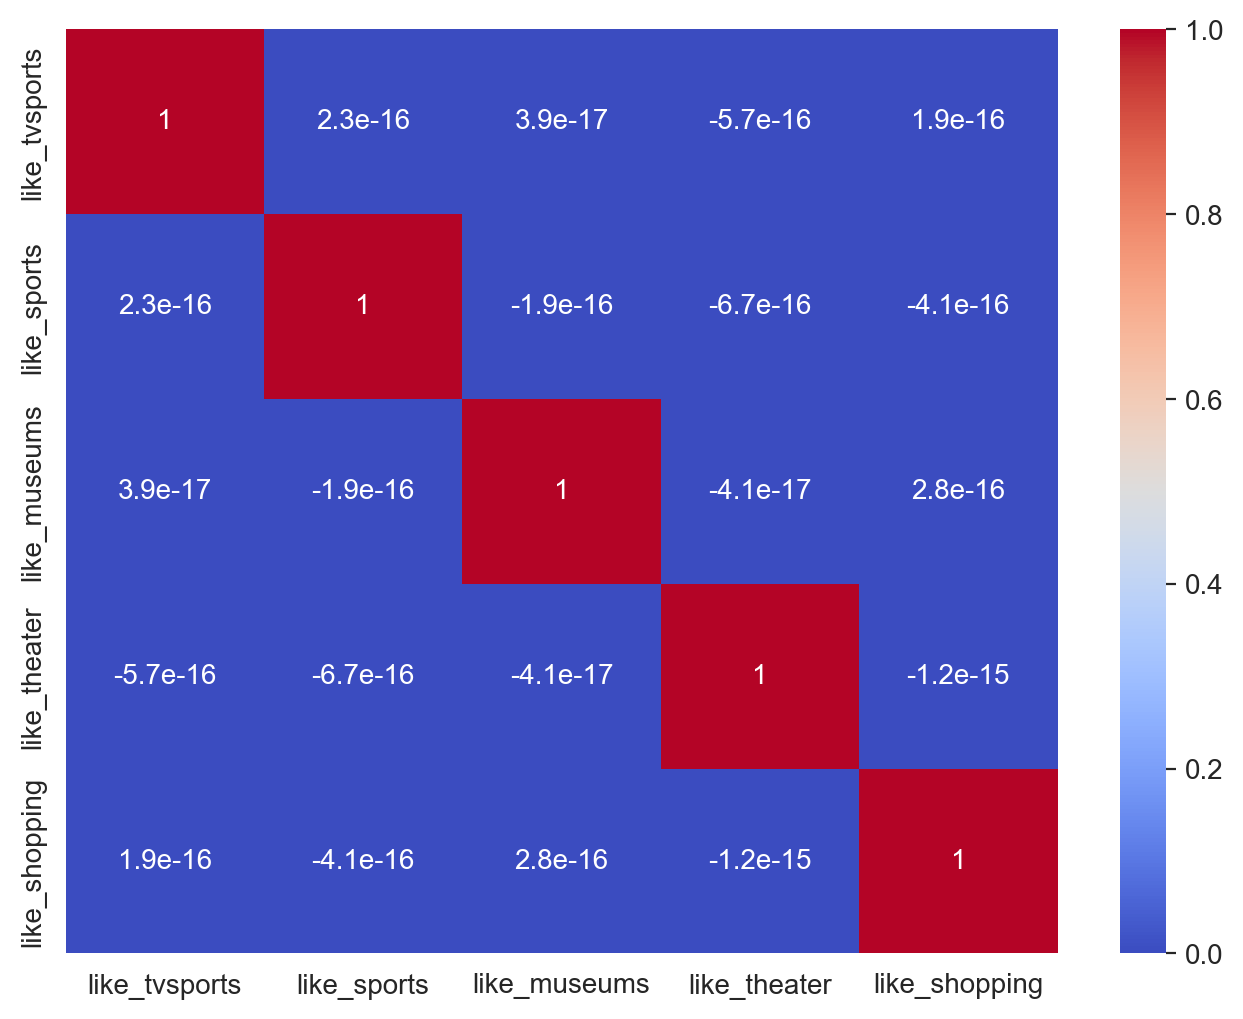

In [107]:
# A:
plt.figure(figsize=(8,6))
sns.heatmap(like_transformed.corr(), 
            annot = True, 
            cmap = 'coolwarm');

---

### 8) Use PCA for dimensionality reduction.

Using linear regression, let's predict whether or not a user likes reading.

**The key question:** Can we get the same prediction accuracy using only the first three principal components as features versus using all five original values as features?

In [109]:
reading = sd['like_reading'].values

**8.A) Linear regression cross-validated on original variables (`sd_like.values`).**

- What is the mean cross-validation score?
- Keep in mind that linear regression uses $R^2$ for score, so one is the ideal score.

In [115]:
# A:
lr = LinearRegression()
cv = cross_val_score(lr, like_transformed.values, reading, cv=5)
print(f' Cross Val Score : {np.round(cv.mean(), 2)}')

 Cross Val Score : 0.09


**8.B) Linear regression on the first principal component.**

- What is the mean cross-validation score?

In [119]:
# A:
like_pca = PCA(n_components=1) #n_components = 1 as the question focus only the first component
like_pca.fit(like_transformed)
like_pca_transformed = like_pca.transform(like_transformed)
like_pca_df = pd.DataFrame(like_pca_transformed)

cv = cross_val_score(lr, like_pca_df.values, reading, cv=5)
print(f' Cross Val Score is: {np.round(cv.mean(), 2)}')

 Cross Val Score is: 0.05


**8.C) Linear regression on first three principal components.**

- What is the mean cross-validation score?

In [123]:
# A:
like_pca = PCA(n_components=3)  #n_components = 3 as the question focus only the first 3 components
like_pca.fit(like_transformed)
like_three_pca = pd.DataFrame(like_pca.transform(like_transformed))

cv = cross_val_score(lr, like_three_pca.values, reading, cv=5)
print(f' Cross Val Score is: {np.round(cv.mean(), 2)}')

 Cross Val Score is: 0.09


---

**Check yourself**. The mean cross-validation score should be nearly the same for the first three principal components as it was on the original five-component data.